### Nonlinear Function

Given a $\phi$ and $\phi^{-1}$ (trained in Quantum autoencoder) such that $\phi^{-1}\circ\phi|\alpha\rangle = |\alpha\rangle$ and $dim(\phi|\alpha\rangle) < dim(|\alpha\rangle)$, we want to find a function $f$ such that $\phi^{-1}\circ f\circ\phi|\alpha_k\rangle = |\alpha_{k+1}\rangle$.

In [7]:
import matplotlib.pyplot as plt         
import tensorflow as tf
import numpy as np
import os

import sys

sys.path.append('..')
from utils import *
sys.path.remove('..')


#Some GPU configuration
#Always uses the 1st GPU avalible (if avalible) unless 1st line is uncommented, in which case no GPU is used

#tf.config.set_visible_devices([], 'GPU') #uncomment to set tensorflow to use CPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
elif len(physical_devices) == 0:
    print("Warning: No GPU detected.  Running tensorflow on CPU")

In [2]:
Phi = tf.keras.models.load_model('../Autoencoder/Autoencoder_Trials/models/trial12e300Phi.h5')
Phi_inv = tf.keras.models.load_model('../Autoencoder/Autoencoder_Trials/models/trial12e300Phi_inv.h5')

In [3]:
def predict_single_timestep(state, ideal_compression_3D=True):
    if ideal_compression_3D:
        state = ideal_phi_3D(state)
        return ideal_phi_3D_inv(NonlinearEvolution(np.array([state,])).numpy()[0])
        
    return NonlinearEvolution(np.array([state,])).numpy()[0]
    

In [4]:
def L2_loss(y_true, y_pred):
    return tf.norm(y_true-y_pred, ord=2, axis=-1)

def L2_with_unity_loss(y_true, y_pred):
    '''L2 loss augmented with extra loss for not having a norm of 1'''
    return tf.norm(y_true-y_pred, ord=2, axis=-1) + tf.abs(1. - tf.norm(y_pred, ord=2, axis=-1))

##NOTE: The 2D compression tools do not work, only the 3D ones
def ideal_phi_2D(states):
    theta = np.math.atan2(states[1],states[0]) - np.math.atan2(states[3],states[2])
    r = np.sqrt(states[0]*states[0]+states[1]*states[1])
    return np.array([r, theta])

def ideal_phi_2D_inv(compressed):
    r, theta = compressed[0], compressed[1]
    
    alpha = r*np.cos(theta)
    beta = r*np.sin(theta)
    gamma = np.sqrt(1-r*r)
    delta = 0.
    return np.array([alpha, beta, gamma, delta])

def ideal_phi_3D(state):
    r1 = np.sqrt(state[0]*state[0] + state[1]*state[1])
    r2 = np.sqrt(state[2]*state[2]+state[3]*state[3])
    phi1 = np.math.atan2(state[1],state[0])
    phi2 = np.math.atan2(state[3],state[2])
    return np.array([r1, r2, phi2-phi1])

def ideal_phi_3D_inv(state):
    alpha = state[0]
    beta = 0.
    gamma = state[1]*np.cos(state[2])
    delta = state[1]*np.sin(state[2])
    return np.array([alpha, beta, gamma, delta])


'''
These compressions fail because sign information on the fourth dimension is lost w/ the square root

def ideal_phi_3D(states):
    return np.array([states[0], states[1], states[2]])

def ideal_phi_3D_inv(compressed):
    diff = 1-compressed[0]*compressed[0]-compressed[1]*compressed[1]-compressed[2]*compressed[2]
    if diff >=0.:
        fourth_component = np.sqrt(diff)
    else:
        fourth_component = 0.
    return np.array([compressed[0], compressed[1], compressed[2], fourth_component])
'''

def get_relative_phase(vector):
    '''Returns the relative phase between
    the two complex components of a two
    complex dimensional vector
    Assumes the vector is passed in as a 
    four dimensional real row vector of form
    [real1, imag1, real2, imag2]
    '''
    

    #Tensorflow likes to return a list of a single
    #element sometimes, which breaks this function
    #This does not happen during training, only when
    #manually run on a single vector
    if vector.shape == (4,):
        return tf.atan2(vector[1], vector[0])%(2*np.pi) - tf.atan2(vector[3], vector[2])%(2*np.pi)

    return tf.atan2(vector[:,1],vector[:,0])%(2*np.pi) - tf.atan2(vector[:,3],vector[:,2])%(2*np.pi)

In [5]:
def get_evolution_data(evolution_data, batch_size = None,
                       datadir='../../QuantumTeam/data/evolution_data/', 
                       pre_compress_2D=False, pre_compress_3D=False):
    #evolution_file = datadir+'evolution_data'+str(evolution_data)+'.csv'
    evolution_file = evolution_data
    
    with open(evolution_file, 'r') as f:
        pre_evolution = []
        post_evolution = []
        data = [x.strip().split(',')[1:] for x in f.readlines()[1:]]
        #Convert data from strings to floats
        data = [[float(y) for y in x] for x in data]
        
        if pre_compress_2D:
            data = [ideal_phi_2D(x) for x in data]
        elif pre_compress_3D:
            data = [ideal_phi_3D(x) for x in data]
 
        
        pre_evolution.append(data[0])
        
        for k in data[1:-1]:
            pre_evolution.append(k)
            post_evolution.append(k)
            
        post_evolution.append(data[-1])
        

        ds = tf.data.Dataset.from_tensor_slices((pre_evolution, post_evolution))
        
        
        
        if batch_size == None:
            return ds.shuffle(100000, reshuffle_each_iteration=True)
        
        else:
            return ds.shuffle(100000, reshuffle_each_iteration=True).batch(batch_size)
        

In [62]:
inputs = tf.keras.Input(shape=3)


nonlinear_layer_1 = tf.keras.layers.Dense(64, activation='selu', name='nonlinear_layer_1')(inputs)
nonlinear_layer_2 = tf.keras.layers.Dense(256, activation='selu', name='nonlinear_layer_2')(nonlinear_layer_1)
nonlinear_layer_3 = tf.keras.layers.Dense(512, activation='selu', name='nonlinear_layer_3')(nonlinear_layer_2)
nonlinear_layer_4 = tf.keras.layers.Dense(512, activation='selu', name='nonlinear_layer_4')(nonlinear_layer_3)
nonlinear_layer_5 = tf.keras.layers.Dense(128, activation='selu', name='nonlinear_layer_5')(nonlinear_layer_4)
nonlinear_layer_6 = tf.keras.layers.Dense(32, activation='selu', name='nonlinear_layer_6')(nonlinear_layer_5)
evolved = tf.keras.layers.Dense(3, activation='selu', name='evolved_state_layer')(nonlinear_layer_6)

NonlinearEvolution = tf.keras.Model(inputs=inputs, outputs=evolved)

In [63]:
train_data = get_evolution_data(1, pre_compress_3D=True)
val_data = train_data.skip(int(0.8 * 100000)).batch(int(0.8*100000))
train_data = train_data.take(int(0.8 * 100000)).batch(int(0.8*100000))

In [68]:
NonlinearEvolution.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss=L2_loss, metrics=['mse', 'mae', L2_loss])

In [ ]:
history = NonlinearEvolution.fit(train_data, validation_data=val_data, epochs=500)

In [70]:
write_history(history, NonlinearEvolution,loss='L2_loss',batch_size='80000')

'./datafiles/trial17.data'

In [59]:
append_history(history, trial=15, params={'Learning Rate':.0001})

In [33]:
NonlinearEvolution.save('./models/trial15e2000.h5')

In [17]:
NonlinearEvolution = tf.keras.models.load_model('./models/trial11e4500.h5', compile=False)

In [71]:
predict_single_timestep([1., 0., 0., 0.])

array([0.7731694 , 0.        , 0.05087413, 0.26904121])

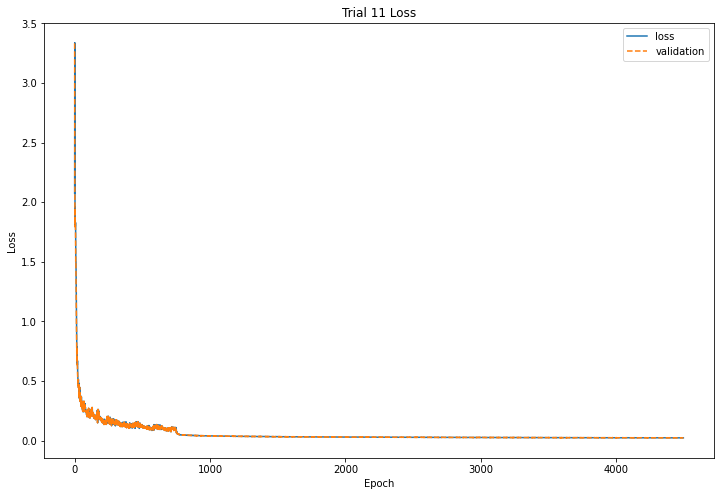

In [25]:
loss_plot(11, savefig=True, mark_lowest=False, size=(12,8))

In [72]:
import qutip as qt

with open('/storage/Documents/programming/machine_learning/BYU/git/QuantumTeam/big_evolve0p1.csv', 'r') as f:
    data = [x.strip().split(',')[1:] for x in f.readlines()[1:]]
    data = np.array([[float(y) for y in x] for x in data])
    
learned_evolution = np.empty([len(data[:1000]), 4])
learned_evolution[0] = data[0]

for i in range(1, len(data[:1000])):
    learned_evolution[i] = ideal_phi_3D_inv(predict_single_timestep(learned_evolution[i-1], ideal_compression_3D=True))

In [33]:
np.count_nonzero(np.isnan(learned_evolution[:1000]))

0

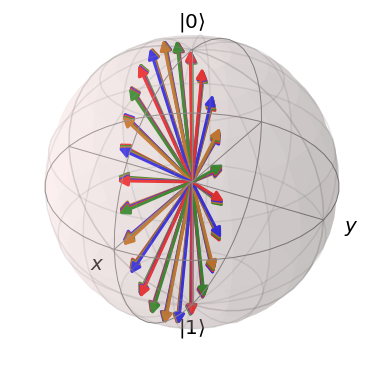

In [73]:
#The actual evolution

bloch = qt.Bloch()

for i in range(100):
    state = np.array([data[i][0]+data[i][1]*1j, data[i][2]+data[i][3]*1j])
    bit=qt.Qobj(state)
    bloch.add_states([bit])
    
bloch.render()

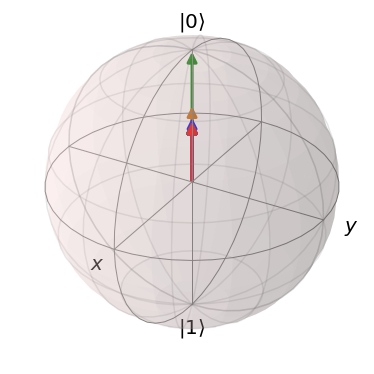

In [74]:
#The predicted evolution

bloch = qt.Bloch()

for i in range(300):
    state = np.array([learned_evolution[i][0]+learned_evolution[i][1]*1j, learned_evolution[i][2]+learned_evolution[i][3]*1j])
    bit=qt.Qobj(state)
    bloch.add_states([bit])
    
bloch.render()

In [50]:
#Create images to be used for animations of the evolution
#VERY SLOW, took about 25 minutes to create 1000 images on my laptop

b = qt.Bloch()

#we should be able to plot the actual and the predicted simultaneously by putting two
#elements in each of these lists and plotting them alternatley (pred1real1, pred2real2, etc.)
b.vector_color = ['g', '#000000']
#b.point_color = ['g', '#000000']
b.point_marker = ['o']

all_true_states = []
all_learned_states = []

for i in range(len(data[:300])):
    b.clear()
    
    #Have to reset colors each time since all true states are plotted then all predicted states
    b.point_color = [x for x in ['g', '#000000'] for k in range(i+1)]
    
    #Plot true evolution in green

    state = np.array([data[i][0]+data[i][1]*1j, data[i][2]+data[i][3]*1j])
    state = qt.Qobj(state)
    b.add_states([state])
    all_true_states.append(state)
    b.add_states(all_true_states, kind='point')
    
    #Plot learned evolution in black

 #   state = np.array([learned_evolution[i][0]+learned_evolution[i][1]*1j, learned_evolution[i][2]+learned_evolution[i][3]*1j])
 #   state = qt.Qobj(state)
 #   b.add_states([state])
 #   all_learned_states.append(state)
 #   b.add_states(all_learned_states, kind='point')
    b.save(dirc='./anim/')


In [34]:
learned_evolution[:20]

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.23121217, -0.25090963, -0.79619288,  0.49966207],
       [-0.73472482,  0.38839373, -0.54414845,  0.11503139],
       [-0.38658991,  0.71209419,  0.60137922,  0.        ],
       [ 0.26576856, -0.27698976,  0.86801744,  0.31494361],
       [ 0.02742376, -1.00098109,  0.00261988,  0.        ],
       [-0.24743181, -0.24452922, -0.51945049,  0.78048328],
       [-0.42050666,  0.37863752, -0.13532926,  0.81332267],
       [ 0.35756603,  0.55405444,  0.51545638,  0.54724303],
       [-0.45817205, -0.74223864,  0.19313359,  0.44928786],
       [-0.72365034, -0.41779068,  0.08195697,  0.54319812],
       [ 0.29001635,  0.22864884,  0.33318523,  0.86752396],
       [ 0.00313379, -0.34369072,  0.0037823 ,  0.93907005],
       [-0.98547488, -0.37544364, -0.14474052,  0.        ],
       [-0.85915774,  0.0951041 ,  0.55215359,  0.        ],
       [ 0.41751695, -0.05582284,  0.79748553,  0.43194935],
       [ 0.56749797, -0.